In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/Wednesday-workingHours.pcap_ISCX.csv


In [3]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import tree
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # Updated import
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
datasetpath = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')
print(f"Dataset downloaded to: {datasetpath}")

Dataset downloaded to: /kaggle/input/


In [5]:
# datasetfile = os.path.join(datasetpath, 'network_intrusion_data.csv')

In [6]:
def load_dataset():
    ds = []
    for root, dirs, files in os.walk(datasetpath):
        for file in files:            
            ds.append(pd.read_csv(os.path.join(root,file)))
    # for i, data in enumerate(ds, start=1):
    #     rows, cols = data.shape
    #     print(f'ds{i} -> {rows} rows, {cols} columns')
    return ds

In [7]:
def preprocess_data(datas):    
    #merging data
    data = pd.concat(datas, axis = 0, ignore_index = True)
    print(f"Before duplicate removal{data.shape}")

    #remove leading or trailing whitespace from col names
    col_names = {col: col.strip() for col in data.columns}
    data.rename(columns = col_names, inplace = True)
    
    #duplicate rows removal
    data = data.drop_duplicates(keep = 'first')
    
    #duplicate columns removal
    columns = data.columns
    identical_columns =[]
    list_control = columns.copy().tolist()
    for col1 in columns:
        for col2 in columns:
            if(col1!=col2):
                if(data[col1].equals(data[col2])):
                    if(col2 not in identical_columns and col2 in list_control):
                        identical_columns.append(col2)
                        if col1 in list_control:
                            list_control.remove(col1)
                        if col2 in list_control: 
                            list_control.remove(col2)
                    elif(col2 in identical_columns and col2 in list_control):
                        if col2 in list_control: 
                            list_control.remove(col2)    
    for col in identical_columns:
        data.drop(columns = col, inplace = True)
                    
    print(f"After duplicate removal{data.shape}")
    
    # Treating infinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #removing rows with missing values
    missing_rows = data.isna().any(axis=1).sum()
    print(f'\nTotal rows with missing values: {missing_rows}')
    data = data.dropna()
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    

    
    print(f"After missing value rows' removal{data.shape}")
    
    #splitting data
    target = data['Label']
    features = data.drop('Label',axis = 1)

    
    return features,target

In [8]:
def encode_data(data):
    encoder = LabelEncoder()
    for col in data.columns:
        if(data[col].dtype == 'object'):
            data[col] = encoder.fit_transform(data[col])
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    return data

In [9]:
def standardize_data(data):
    scaler = StandardScaler()
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    return scaler.fit_transform(data)

In [10]:
# max_samples_per_class = 1000
# def limit_oversampling(y):
#     unique_classes, counts = np.unique(y, return_counts=True)
#     return {cls: min(max_samples_per_class, count * 2) for cls, count in zip(unique_classes, counts)}

In [11]:
# def oversample(data,target):
#     sampler = RandomOverSampler(sampling_strategy = 'not majority')
#     new_data,new_target = sampler.fit_resample(data,target)
#     print("Before oversampling:", Counter(target))
#     print("After oversampling:", Counter(new_target))
#     return new_data, new_target

In [12]:
def undersample(data, target):
    df = pd.DataFrame(data)
    df['class'] = target

    # Apply undersampling, using replace=True if class size < 1000
    df_balanced = df.groupby('class', group_keys=False).apply(
        lambda x: x.sample(n=1000, replace=len(x) < 1000, random_state=42)
    )

    X_balanced = df_balanced.drop(columns=['class']).values
    y_balanced = df_balanced['class'].values
    print("Before undersampling:", Counter(target))
    print("After undersampling:", Counter(y_balanced))
    return X_balanced, y_balanced



In [13]:
def dimensionality_reduction(data):    
    pca = PCA(n_components = 10)
    data = pca.fit_transform(data)
    return data

In [14]:
def decision_tree(features, labels, test_x, test_y):
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(features,labels)
    # tree.plot_tree(classifier, max_depth = 3)
    predictions = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    report = classification_report(test_y, predictions) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [15]:
def extra_tree(features, labels, test_x, test_y):
    classifier = ExtraTreesClassifier(n_estimators = 100)
    classifier.fit(features,labels)
    predictions = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    report = classification_report(test_y, predictions,zero_division=1) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [16]:
def random_forest(features,labels,test_x,test_y):
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(features,labels)
    y_pred = model.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    report = classification_report(test_y, y_pred) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [17]:
def xg_boost(features,labels,test_x,test_y):
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    test_y_encoded = encoder.transform(test_y)
    model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    model.fit(features,labels)    
    y_pred_enc = model.predict(test_x)
    y_pred = encoder.inverse_transform(y_pred_enc)
    accuracy = accuracy_score(test_y, y_pred)
    report = classification_report(test_y, y_pred) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")


In [18]:
class rnnLSTM(nn.Module):    
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=15):
        super(rnnLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):       
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  
        
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]  
        
        # Pass through the fully connected layer
        out = self.fc(lstm_out)
        return out
    

In [19]:
class CNNIntrusionDetection(nn.Module):
    def __init__(self, input_channels=1, num_classes=15): 
        super(CNNIntrusionDetection, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 10, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  
        x = self.conv1(x)   
        x = self.relu(x)
        x = self.conv2(x)  
        x = self.relu(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)    
        x = self.relu(x)
        x = self.fc2(x)   
        return self.softmax(x)

In [20]:
def train_cnn(model, train_loader, criterion, optimizer, epochs=50, device='cpu'):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss /= len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    return train_losses, train_accuracies

In [21]:
def evaluate_cnn(model, test_loader, criterion, device='cpu'):
    model.eval()
    val_losses = []
    all_preds, all_labels = [], []
    total = 0
    correct = 0
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    epoch_val_loss /= len(test_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:\n', classification_report(all_labels, all_preds))
    return val_losses, val_accuracy

In [22]:
ds = load_dataset()

In [23]:
ds,target = preprocess_data(ds)

Before duplicate removal(2830743, 79)
After duplicate removal(2522362, 67)

Total rows with missing values: 1564
Total NaN values: 0
After missing value rows' removal(2520798, 67)


In [24]:
ds = encode_data(ds)

Total NaN values: 0


In [25]:
ds = standardize_data(ds)

Total NaN values: 0


In [26]:
ds = dimensionality_reduction(ds)
print("DS shape:", ds.shape)
ds = np.column_stack((ds,target))
print(ds)

DS shape: (2520798, 10)
[[-1.121080183696839 0.9543429656086991 0.12922066285747305 ...
  -0.18064566823388298 -0.07630219797099877 'BENIGN']
 [-1.1200664663829 0.95371067503315 0.12937996114777744 ...
  -0.18068694328627777 -0.07664835498290519 'BENIGN']
 [-2.1007554074134602 -0.3939943482172183 -0.01982060882253624 ...
  -0.2527338318905762 2.091050832751554 'BENIGN']
 ...
 [-2.109981871623396 -0.5233748489332611 0.08679854419093239 ...
  0.06832772779068724 0.09201910934392601 'BENIGN']
 [-1.9119721331127522 -0.2786109888843269 -0.05024927479529957 ...
  0.11678219766677989 -0.42233007296166764 'BENIGN']
 [-1.9864280397883407 -0.281466061600366 -0.03719148387766751 ...
  0.13979623715976663 -0.4843867260774417 'BENIGN']]


In [27]:
train_data, test_data = train_test_split(ds, test_size = 0.1)
x_train = train_data[:,:-1]
y_train = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

In [28]:
# x_train,y_train = oversample(x_train,y_train)
# print("DS shape:", ds.shape)

In [29]:
x_train,y_train = undersample(x_train,y_train)

Before undersampling: Counter({'BENIGN': 1885513, 'DoS Hulk': 155545, 'DDoS': 115186, 'PortScan': 81685, 'DoS GoldenEye': 9295, 'FTP-Patator': 5325, 'DoS slowloris': 4854, 'DoS Slowhttptest': 4706, 'SSH-Patator': 2899, 'Bot': 1738, 'Web Attack � Brute Force': 1334, 'Web Attack � XSS': 577, 'Infiltration': 33, 'Web Attack � Sql Injection': 17, 'Heartbleed': 11})
After undersampling: Counter({'BENIGN': 1000, 'Bot': 1000, 'DDoS': 1000, 'DoS GoldenEye': 1000, 'DoS Hulk': 1000, 'DoS Slowhttptest': 1000, 'DoS slowloris': 1000, 'FTP-Patator': 1000, 'Heartbleed': 1000, 'Infiltration': 1000, 'PortScan': 1000, 'SSH-Patator': 1000, 'Web Attack � Brute Force': 1000, 'Web Attack � Sql Injection': 1000, 'Web Attack � XSS': 1000})


<ipython-input-12-18c1c5b760e8>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(


In [32]:
decision_tree(x_train,y_train, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 88.22%
Report = 
              precision    recall  f1-score   support

           0       1.00      0.86      0.93    209544
           1       0.03      1.00      0.07       210
          10       0.66      0.98      0.79      9009
          11       0.13      0.98      0.23       320
          12       0.08      0.69      0.14       136
          13       0.01      0.50      0.01         4
          14       0.02      0.40      0.04        75
           2       0.94      0.99      0.96     12828
           3       0.18      0.98      0.31       991
           4       0.87      0.98      0.92     17301
           5       0.24      0.98      0.38       522
           6       0.18      0.99      0.30       531
           7       0.38      0.99      0.55       606
           8       0.00      0.00      0.00         0
           9       0.00      0.67      0.00         3

    accuracy                           0.88    252080
   macro avg       0.31      0.80      0.37    25208

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/50, Loss: 2.1263, Accuracy: 68.87%
Epoch 20/50, Loss: 2.1095, Accuracy: 70.55%
Epoch 30/50, Loss: 2.0590, Accuracy: 75.61%
Epoch 40/50, Loss: 2.0455, Accuracy: 76.96%
Epoch 50/50, Loss: 2.0380, Accuracy: 77.69%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7426
Precision: 0.9381
Recall: 0.7426
F1 Score: 0.8100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82    209544
           1       0.00      0.44      0.01       210
           2       0.61      0.98      0.75      9009
           3       0.10      0.93      0.18       320
           4       0.00      0.09      0.01       136
           5       0.00      0.50      0.00         4
           6       0.01      0.92      0.03        75
           7       0.76      1.00      0.87     12828
           8       0.19      0.94      0.31       991
           9       0.65      0.99      0.79     17301
          10       0.21      0.72      0.32       522
          11       0.08      0.90      0.15       531
          12       0.26      0.64      0.37       606
          13       0.00      0.00      0.00         0
          14       0.00      0.67      0.00         3

    accuracy                           0.74    252080
   macro avg       0.26      0.69      0.31    252080
we

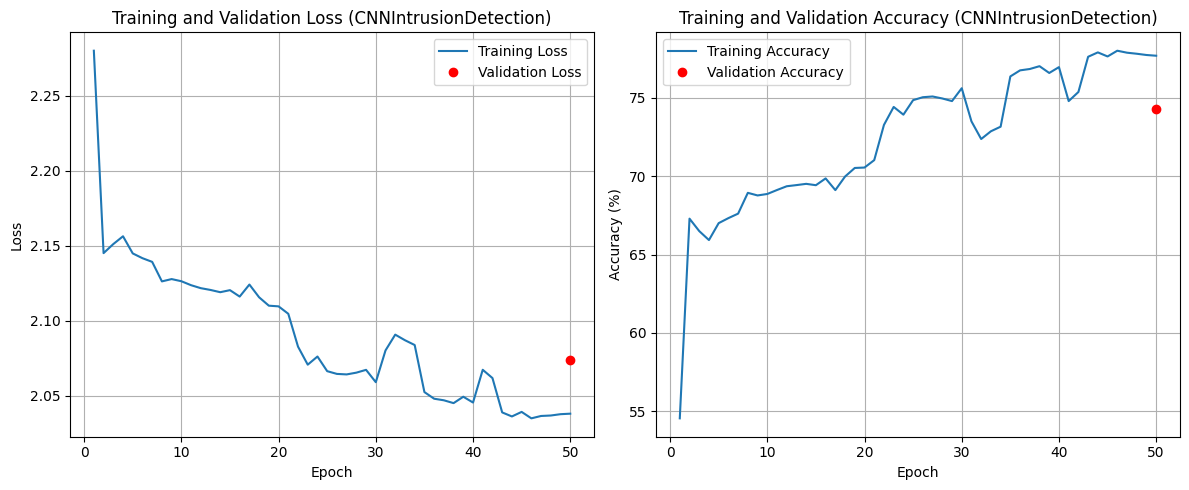

In [31]:
# CNN
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=str)
y_test = np.array(y_test, dtype=str)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

num_classes = len(np.unique(y_train_encoded))  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNIntrusionDetection(input_channels=1, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train_cnn(model, train_loader, criterion, optimizer, epochs=50, device=device)
val_losses, val_accuracy = evaluate_cnn(model, test_loader, criterion, device=device)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_losses, label="Training Loss")
plt.plot([50], val_losses, 'ro', label="Validation Loss")  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (CNNIntrusionDetection)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracies, label="Training Accuracy")
plt.plot([50], [val_accuracy], 'ro', label="Validation Accuracy") 
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy (CNNIntrusionDetection)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
extra_tree(x_train,y_train, x_test, y_test)

Accuracy = 93.29%
Report = 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    209544
           1       0.05      1.00      0.09       210
          10       0.71      0.99      0.83      9009
          11       0.26      0.98      0.41       320
          12       0.19      0.76      0.30       136
          13       0.02      0.50      0.04         4
          14       0.06      0.37      0.10        75
           2       0.98      0.99      0.98     12828
           3       0.29      0.99      0.45       991
           4       0.86      0.99      0.92     17301
           5       0.39      1.00      0.56       522
           6       0.55      0.99      0.71       531
           7       0.97      1.00      0.98       606
           8       0.00      1.00      0.00         0
           9       0.01      0.67      0.01         3

    accuracy                           0.93    252080
   macro avg       0.42      0.88      0.49    25208

In [34]:
random_forest(x_train,y_train, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 92.85%
Report = 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    209544
           1       0.04      1.00      0.08       210
          10       0.69      0.99      0.82      9009
          11       0.36      0.99      0.53       320
          12       0.24      0.71      0.36       136
          13       0.01      0.50      0.02         4
          14       0.07      0.47      0.12        75
           2       0.97      0.99      0.98     12828
           3       0.26      0.99      0.42       991
           4       0.86      0.99      0.92     17301
           5       0.45      1.00      0.62       522
           6       0.51      0.99      0.68       531
           7       0.94      1.00      0.97       606
           8       0.00      0.00      0.00         0
           9       0.00      0.67      0.01         3

    accuracy                           0.93    252080
   macro avg       0.43      0.81      0.50    25208

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
xg_boost(x_train,y_train, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 92.09%
Report = 
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    209544
           1       0.04      1.00      0.07       210
          10       0.73      0.99      0.84      9009
          11       0.27      0.98      0.43       320
          12       0.12      0.58      0.19       136
          13       0.01      0.50      0.01         4
          14       0.03      0.48      0.06        75
           2       0.97      0.99      0.98     12828
           3       0.25      0.99      0.40       991
           4       0.89      0.98      0.94     17301
           5       0.33      1.00      0.50       522
           6       0.41      0.99      0.58       531
           7       0.93      1.00      0.96       606
           8       0.00      0.00      0.00         0
           9       0.00      0.67      0.00         3

    accuracy                           0.92    252080
   macro avg       0.40      0.80      0.46    25208

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/50], Training Loss: 0.4256, Training Accuracy: 84.97%, Validation Loss: 0.9558, Validation Accuracy: 66.23%
Epoch [20/50], Training Loss: 0.3024, Training Accuracy: 88.43%, Validation Loss: 0.7561, Validation Accuracy: 73.41%
Epoch [30/50], Training Loss: 0.2566, Training Accuracy: 90.23%, Validation Loss: 0.6701, Validation Accuracy: 77.09%
Epoch [40/50], Training Loss: 0.2320, Training Accuracy: 90.80%, Validation Loss: 0.6025, Validation Accuracy: 80.07%
Epoch [50/50], Training Loss: 0.2152, Training Accuracy: 91.65%, Validation Loss: 0.5535, Validation Accuracy: 81.69%


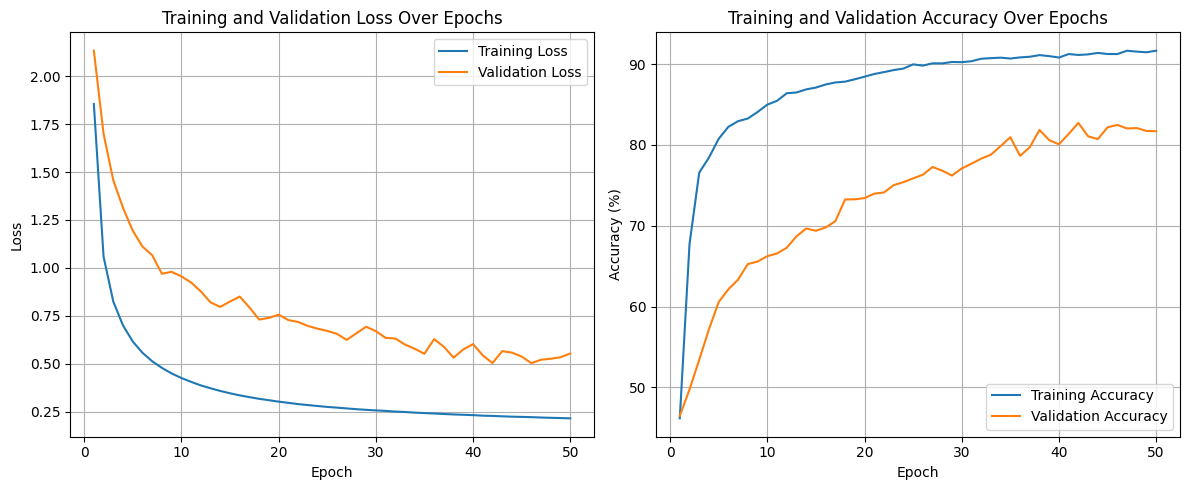

In [30]:
# LSTM
x_train = np.array(x_train, dtype=np.float32) 
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=str) 
y_test = np.array(y_test, dtype=str)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

x_train = torch.tensor(np.array(x_train, dtype=np.float32))
y_train = torch.tensor(y_train_encoded, dtype=torch.long)  
x_test = torch.tensor(np.array(x_test, dtype=np.float32))
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


num_classes = len(np.unique(y_train_encoded))
input_size = x_train.shape[1]


model = rnnLSTM(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.unsqueeze(1)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_X.size(0)  # Accumulate loss
        
        _, predicted = torch.max(outputs, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    epoch_train_loss /= len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.unsqueeze(1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item() * batch_X.size(0)  # Accumulate loss
            
            _, predicted = torch.max(outputs, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()
    
    epoch_val_loss /= len(test_loader.dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, "
              f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
